<a href="https://colab.research.google.com/github/oimartin/company_bankruptcy_predictions/blob/main/Notebook_bankrupt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# Model Fit Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

data = pd.read_csv('https://raw.githubusercontent.com/oimartin/company_bankruptcy_predictions/main/data/data.csv')
data.shape

(6819, 96)

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

# EDA

## Missing Values and Duplicate Values

In [3]:
# double check for missing values
nulls = data.isnull().sum()
nulls[nulls >=1]

Series([], dtype: int64)

There are a total of 6819 rows and no missing values for the 95 input features. The bankruptcy column or output feature also has no missing values 

In [4]:
# Check for duplicated data
data.duplicated().sum()

0

## Bankrupt?


In [5]:
# Column names originally have extra whitespace
data.columns = data.columns.str.replace(' ', '')

In [6]:
data['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

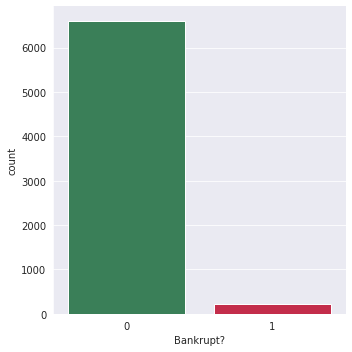

In [7]:
sns.set_style("darkgrid")
ax = sns.catplot(x='Bankrupt?', data=data, kind='count', palette=['seagreen', 'crimson'])
ax.savefig('Data_on_Bankrupt_or_Not_Bankrupt_Companies.png')
plt.show()

Within the dataset, there are few corresponding rows that indicate a company is bankrupt

## Features

In [8]:
data.describe()

,Bankrupt?,ROA(C)beforeinterestanddepreciationbeforeinterest,ROA(A)beforeinterestand%aftertax,ROA(B)beforeinterestanddepreciationaftertax,OperatingGrossMargin,RealizedSalesGrossMargin,OperatingProfitRate,Pre-taxnetInterestRate,After-taxnetInterestRate,Non-industryincomeandexpenditure/revenue,Continuousinterestrate(aftertax),OperatingExpenseRate,Researchanddevelopmentexpenserate,Cashflowrate,Interest-bearingdebtinterestrate,Taxrate(A),NetValuePerShare(B),NetValuePerShare(A),NetValuePerShare(C),PersistentEPSintheLastFourSeasons,CashFlowPerShare,RevenuePerShare(Yuan¥),OperatingProfitPerShare(Yuan¥),PerShareNetprofitbeforetax(Yuan¥),RealizedSalesGrossProfitGrowthRate,OperatingProfitGrowthRate,After-taxNetProfitGrowthRate,RegularNetProfitGrowthRate,ContinuousNetProfitGrowthRate,TotalAssetGrowthRate,NetValueGrowthRate,TotalAssetReturnGrowthRateRatio,CashReinvestment%,CurrentRatio,QuickRatio,InterestExpenseRatio,Totaldebt/Totalnetworth,Debtratio%,Networth/Assets,Long-termfundsuitabilityratio(A),...,CurrentAssets/TotalAssets,Cash/TotalAssets,QuickAssets/CurrentLiability,Cash/CurrentLiability,CurrentLiabilitytoAssets,OperatingFundstoLiability,Inventory/WorkingCapital,Inventory/CurrentLiability,CurrentLiabilities/Liability,WorkingCapital/Equity,CurrentLiabilities/Equity,Long-termLiabilitytoCurrentAssets,RetainedEarningstoTotalAssets,Totalincome/Totalexpense,Totalexpense/Assets,CurrentAssetTurnoverRate,QuickAssetTurnoverRate,WorkingcapitcalTurnoverRate,CashTurnoverRate,CashFlowtoSales,FixedAssetstoAssets,CurrentLiabilitytoLiability,CurrentLiabilitytoEquity,EquitytoLong-termLiability,CashFlowtoTotalAssets,CashFlowtoLiability,CFOtoAssets,CashFlowtoEquity,CurrentLiabilitytoCurrentAssets,Liability-AssetsFlag,NetIncometoTotalAssets,TotalassetstoGNPprice,No-creditInterval,GrossProfittoSales,NetIncometoStockholder'sEquity,LiabilitytoEquity,DegreeofFinancialLeverage(DFL),InterestCoverageRatio(InterestexpensetoEBIT),NetIncomeFlag,EquitytoLiability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,0.012679,3.237684e+09,2.598292e+09,0.017036,1.082750e+08,0.138667,0.033390,0.033474,0.033480,0.033263,0.017611,5.170709e+07,0.027942,0.033180,0.012079,0.010752,0.013

In [9]:
# Find columns that are binary and other columns with wide ranges
min0_max1 = []
addtl_col = []
for column in data.columns:
  min = data[column].describe()[3]
  max = data[column].describe()[7]
  if (min == 0) and (max == 1):
    min0_max1.append(column)
  else:
    addtl_col.append(column)

display(len(min0_max1))
display(len(addtl_col))

71

25

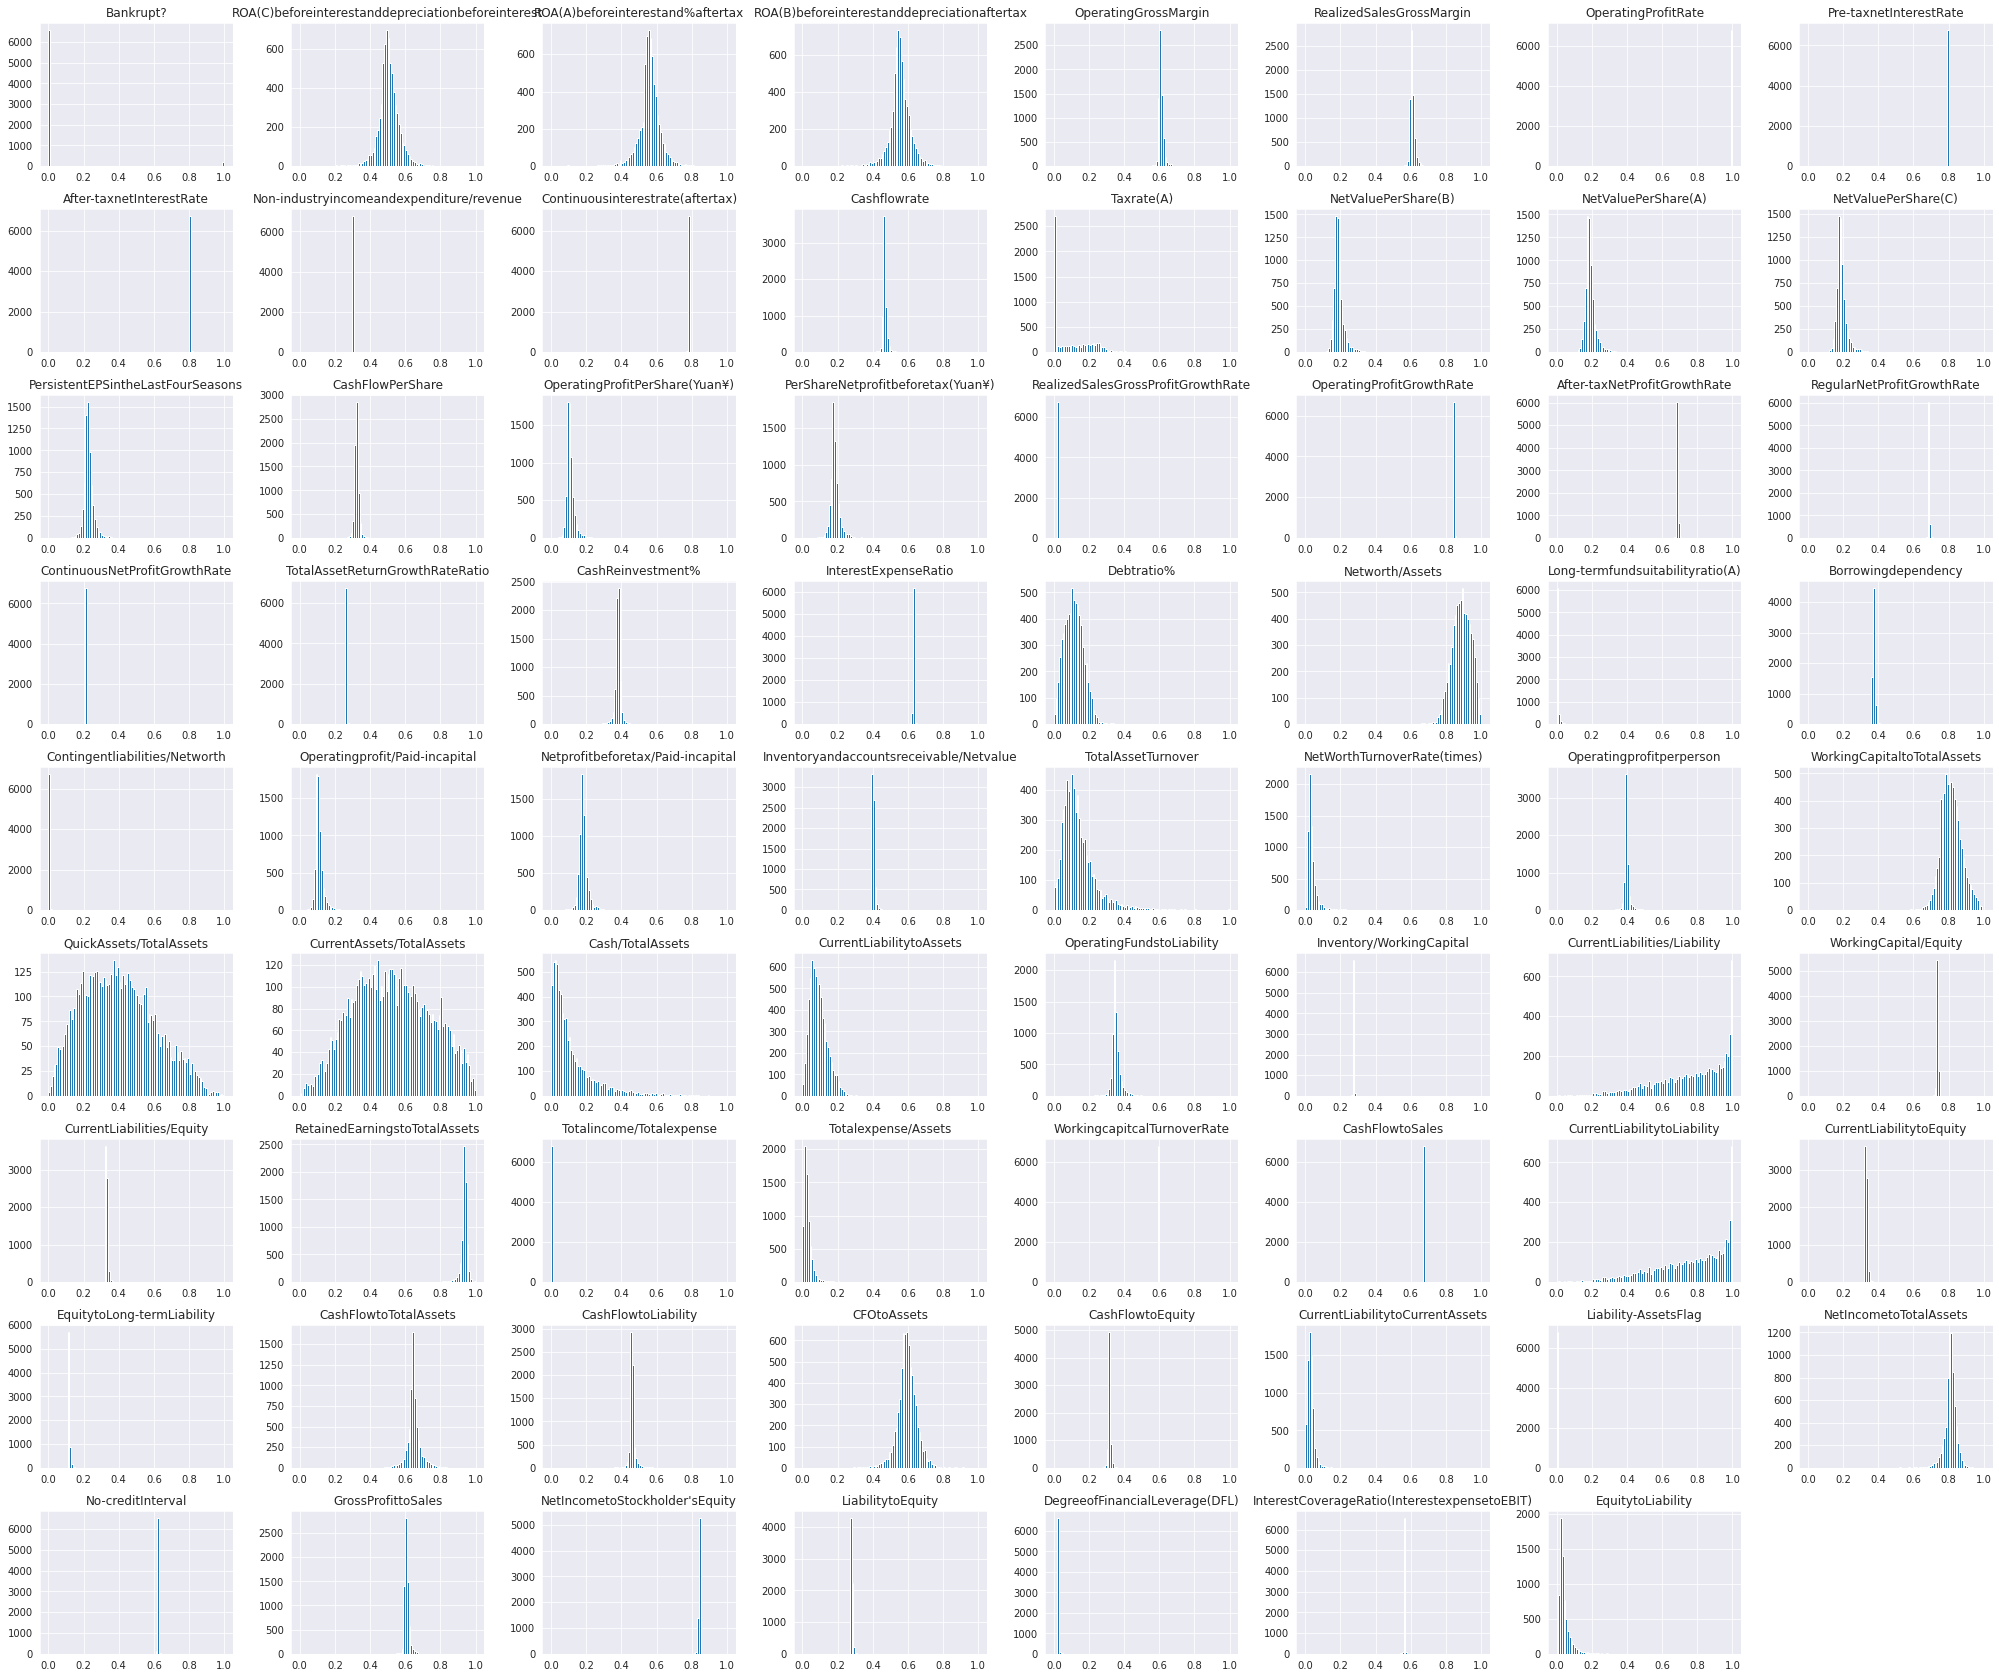

In [10]:
# View distribution of data with min0 and max1
sns.set_style("darkgrid")
data[min0_max1].hist(figsize = (35,30), bins = 100)
plt.savefig('Data_with_Min_0_and_Max_1_Distributions')
plt.show()

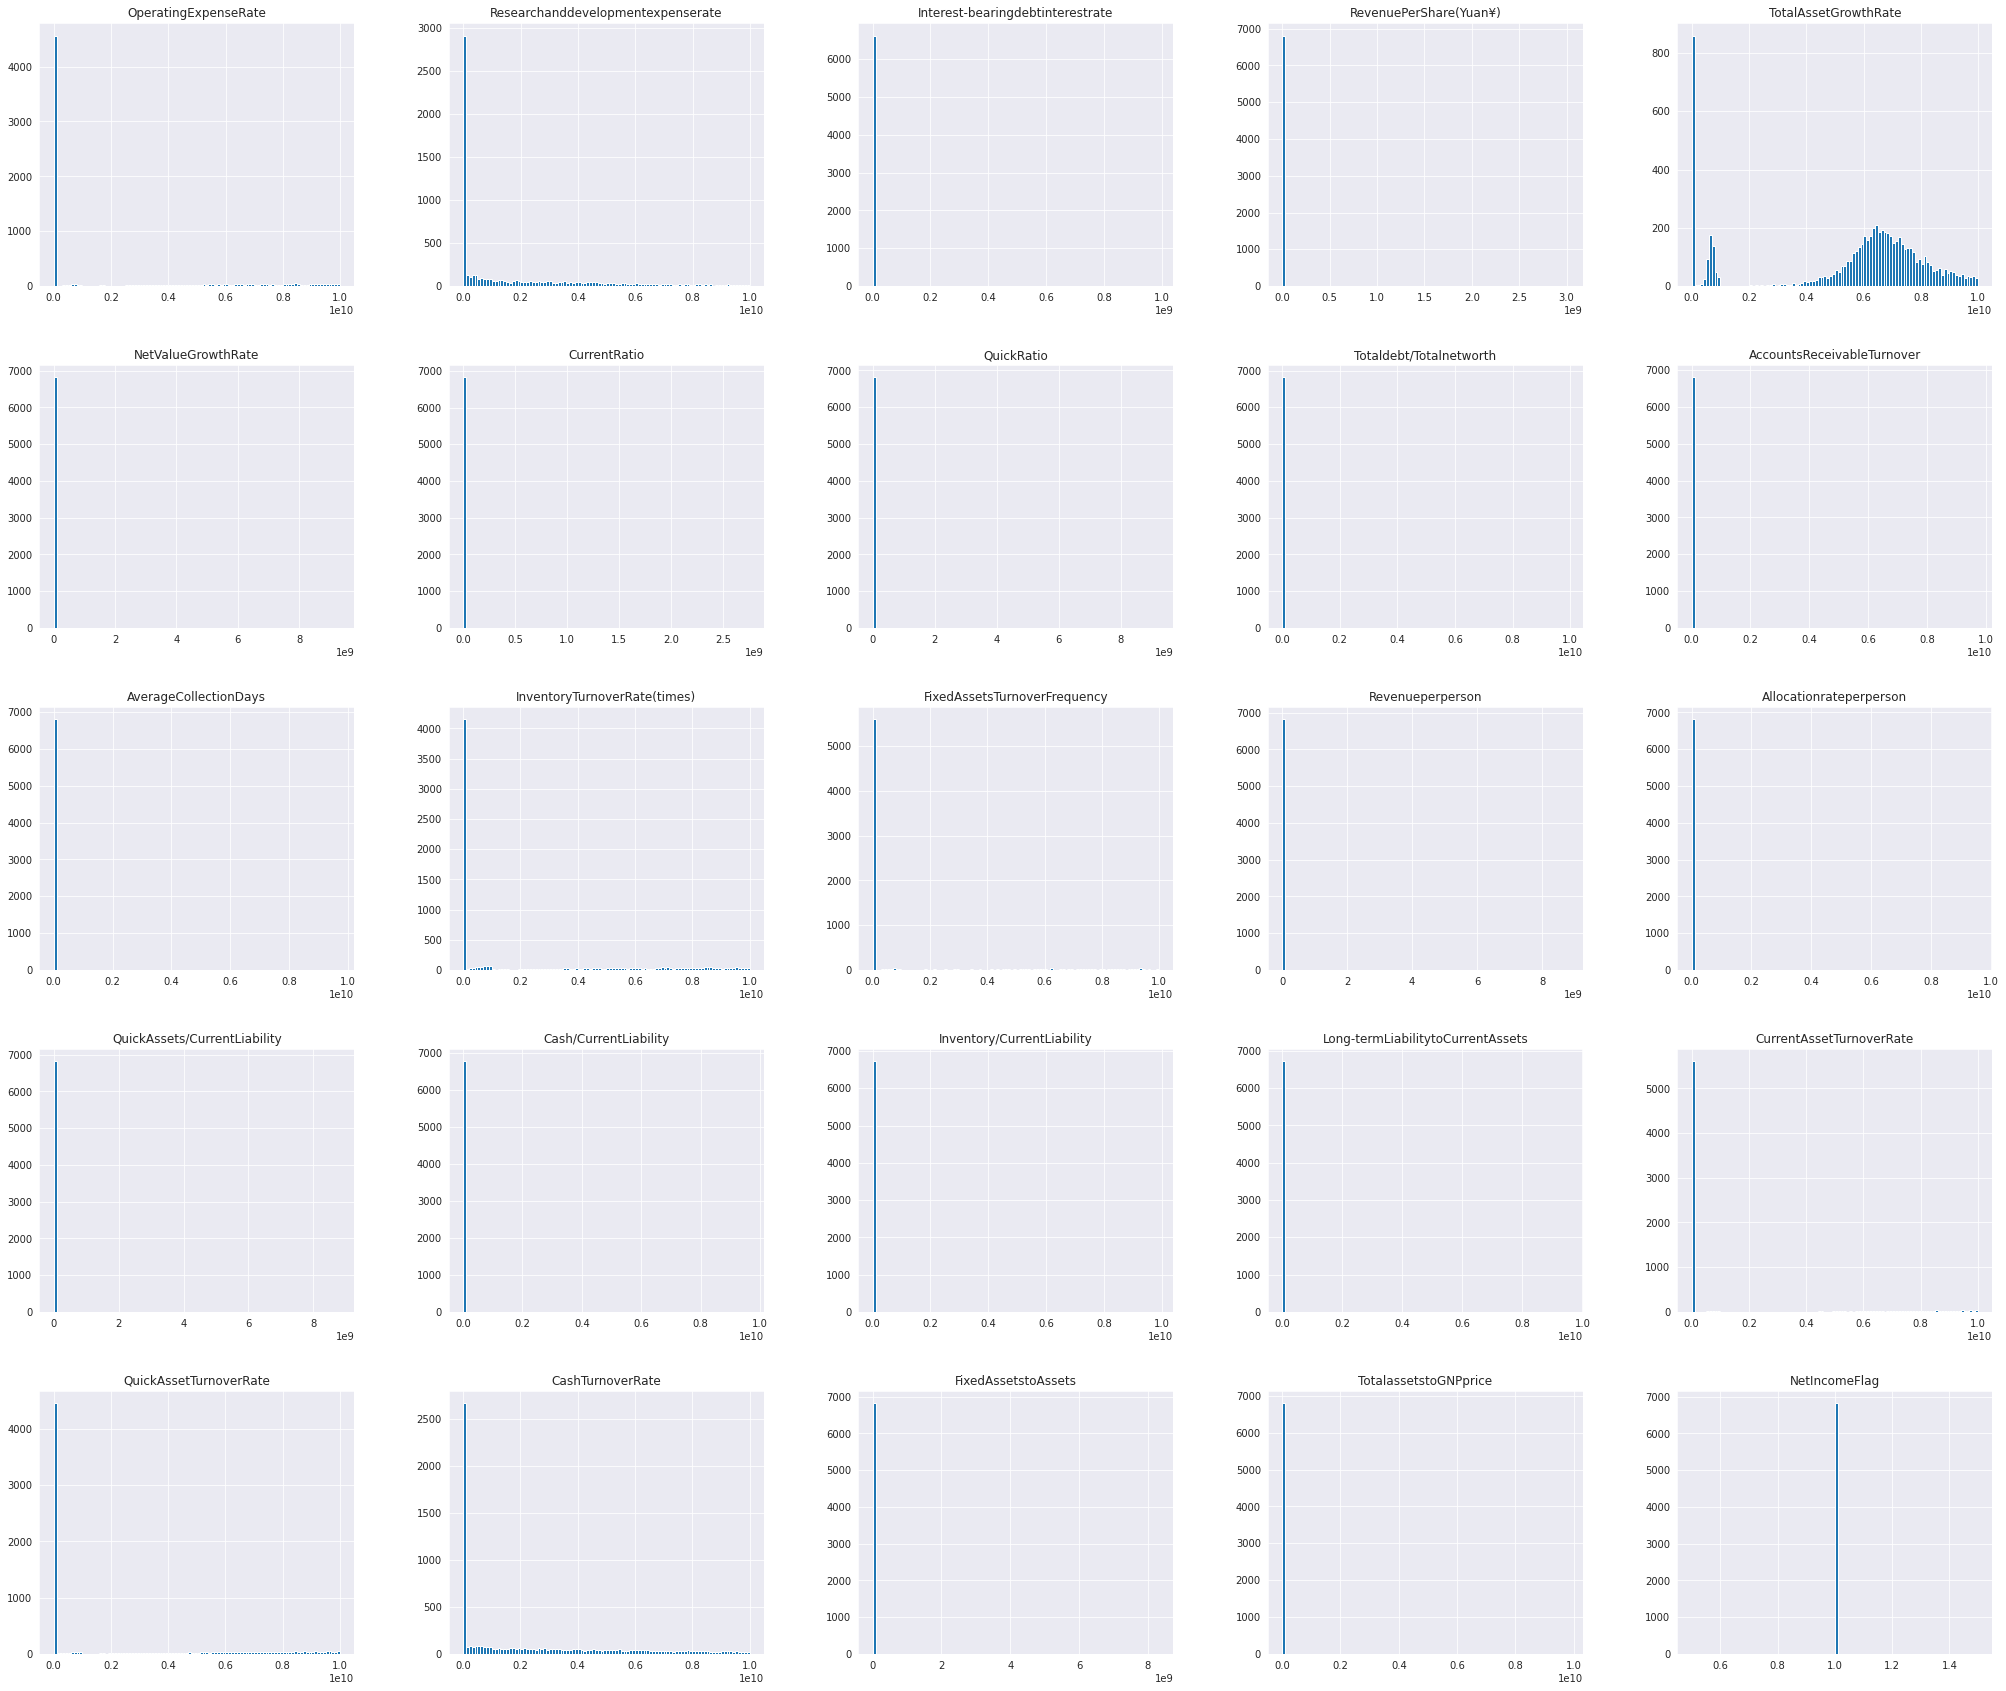

In [11]:
sns.set_style("darkgrid")
data[addtl_col].hist(figsize = (35,30), bins = 100)
plt.savefig('Continuous_data_distributions.png')
plt.show()

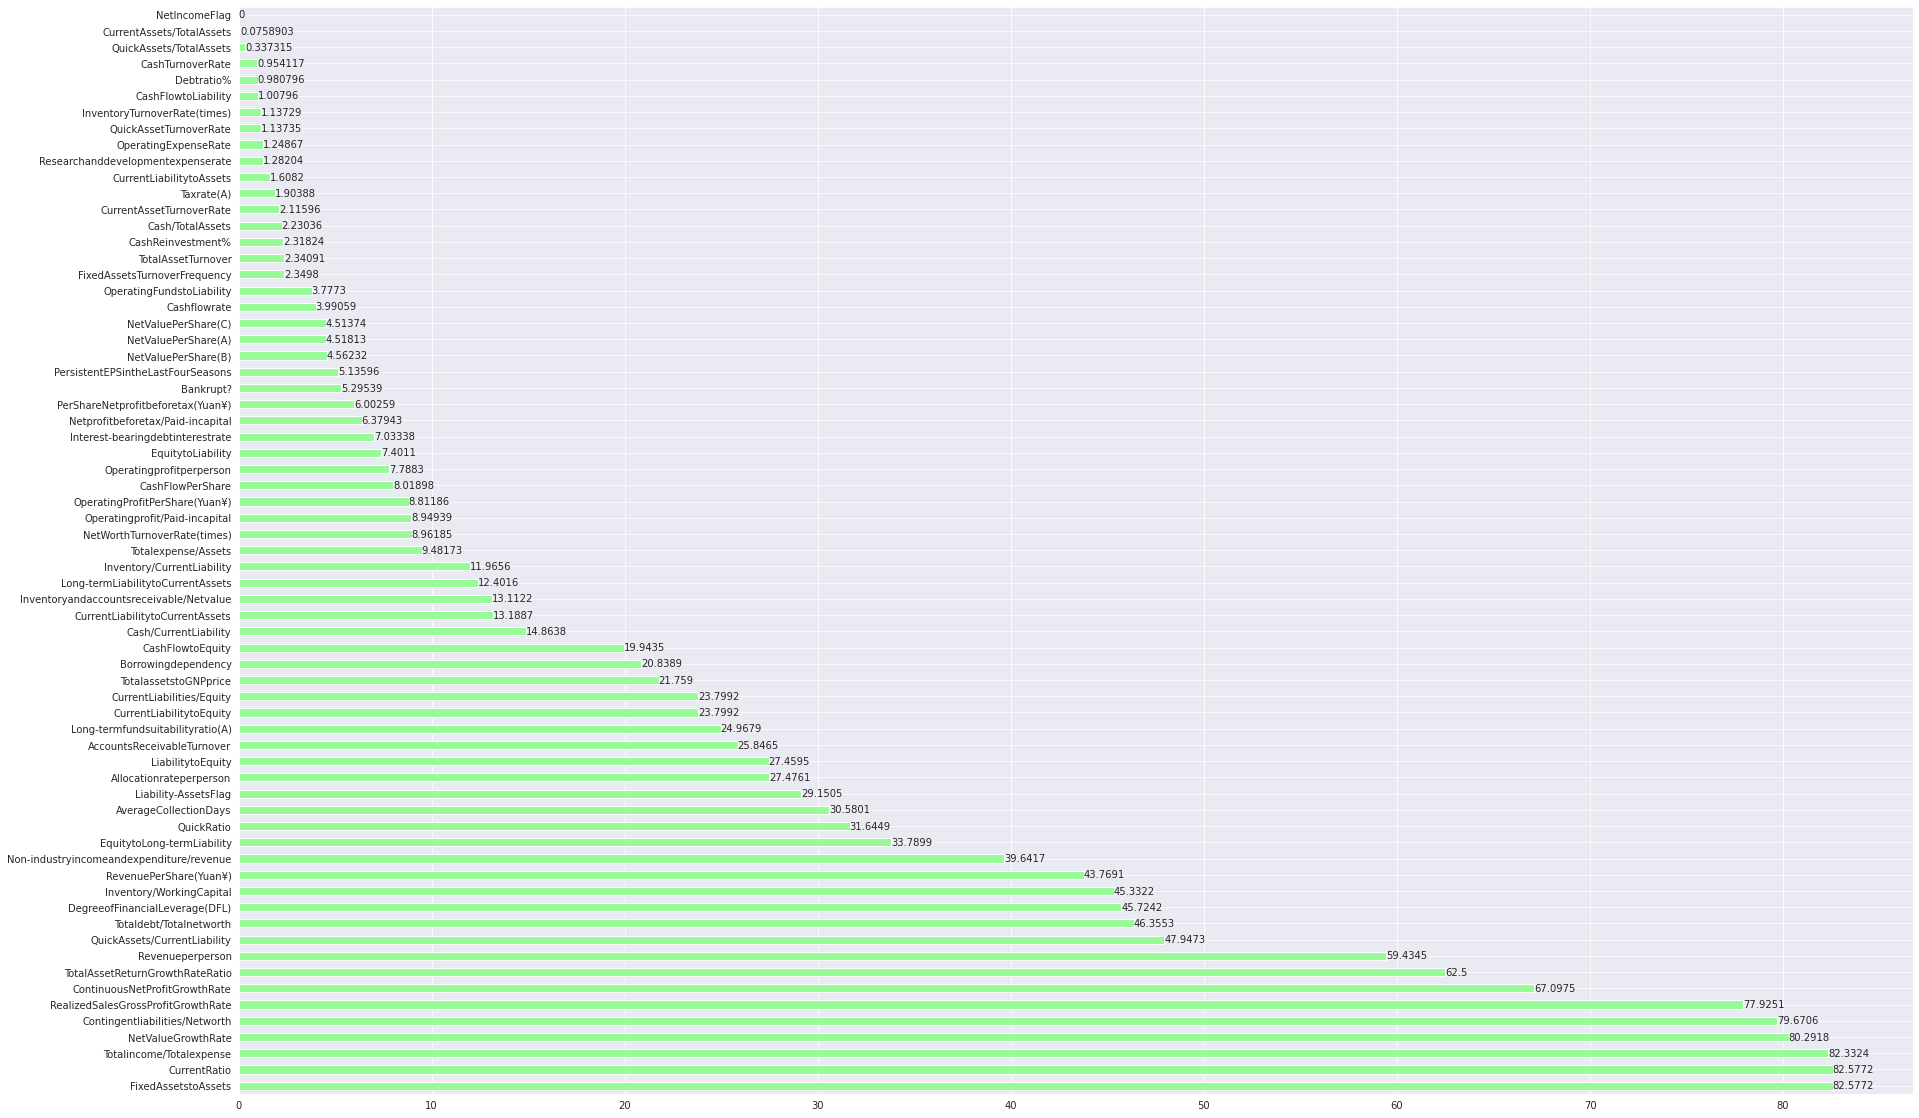

In [12]:
skew = data.skew()
skew_pos = skew[skew >=0].sort_values(ascending=False)
skew_neg = skew[skew <0].sort_values(ascending=True)

sns.set_style("darkgrid")

plt.figure(figsize=(30,20))
ax = skew_pos.plot.barh(color='palegreen')
ax.bar_label(ax.containers[0])
plt.savefig('positively_skewed_data.png')

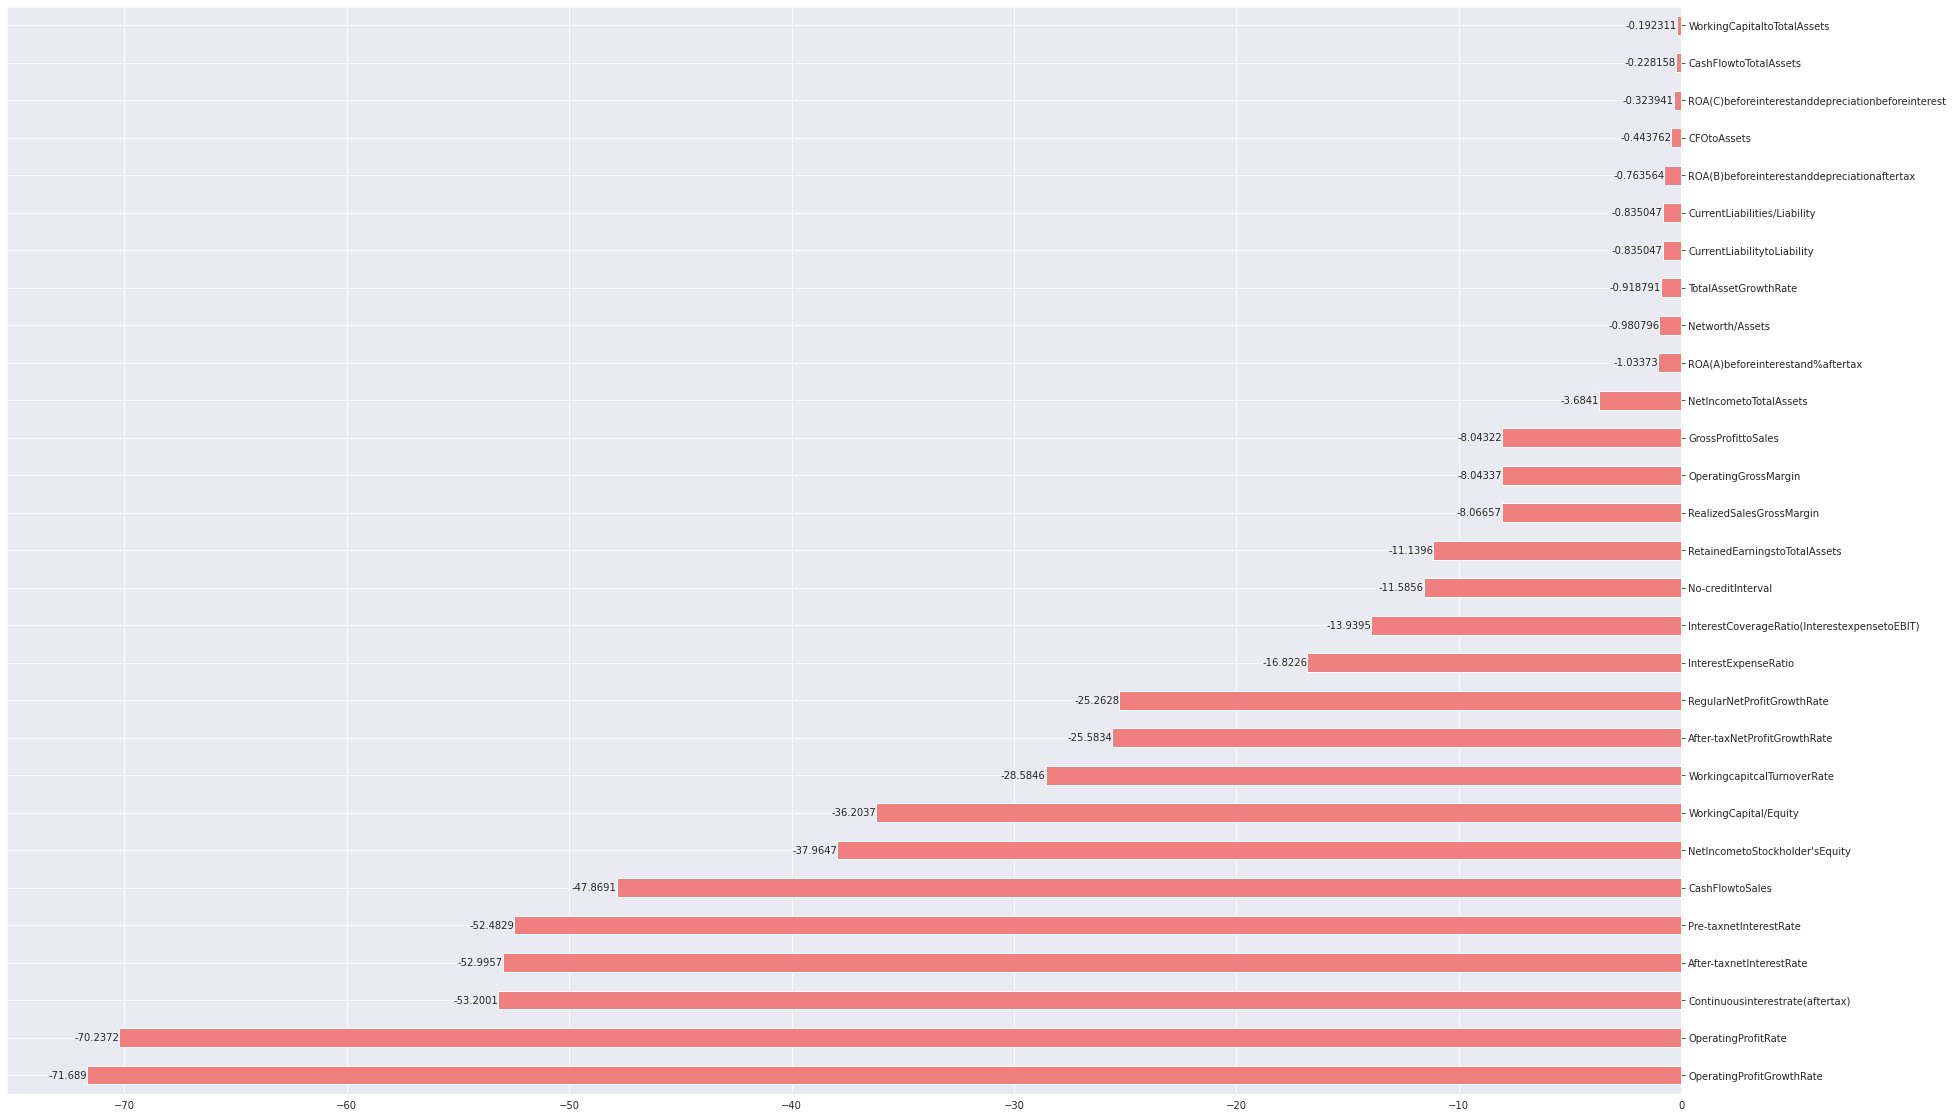

In [13]:
sns.set_style("darkgrid")

plt.figure(figsize=(30,20))
ax = skew_neg.plot.barh(color='lightcoral')
ax.bar_label(ax.containers[0])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.savefig('negatively_skewed_data.png')


In [14]:
top_skew_pos = skew_pos.head()
bottom_skew_neg = skew_neg.head()

In [15]:
def strip_violin (data_frame, x_axis, y_feat, skew,axis):
  sns.stripplot(data=data_frame, x=x_axis, y=y_feat, palette=['seagreen', 'crimson'],ax=axis)
  sns.violinplot(x=x_axis, y=y_feat, data=data_frame, inner=None, color=".8", ax=axis)
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  axis.text(0.25, 1.10, f"Skew = {round(skew,2)}", transform=axis.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
  return axis

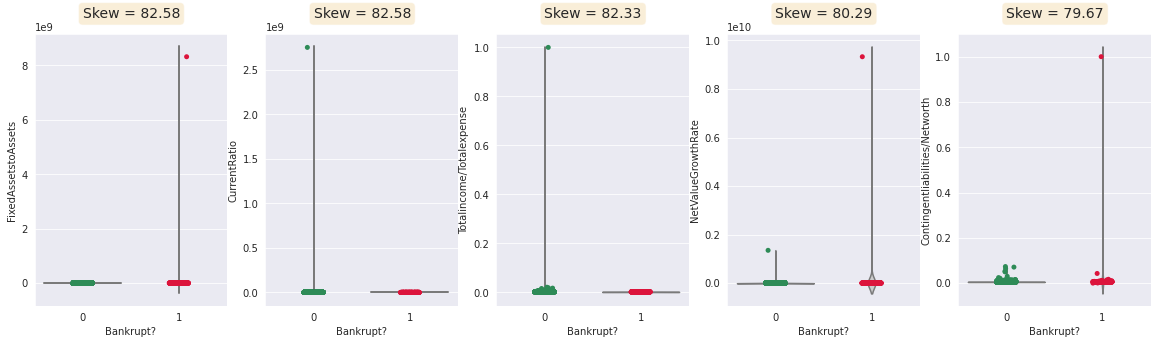

In [16]:
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(data, 'Bankrupt?', top_skew_pos.index[0], top_skew_pos[0], ax0)
strip_violin(data, 'Bankrupt?', top_skew_pos.index[1], top_skew_pos[1], ax1)
strip_violin(data, 'Bankrupt?', top_skew_pos.index[2], top_skew_pos[2], ax2)
strip_violin(data, 'Bankrupt?', top_skew_pos.index[3], top_skew_pos[3], ax3)
strip_violin(data, 'Bankrupt?', top_skew_pos.index[4], top_skew_pos[4], ax4)

plt.savefig('heavily_positively_skewed_violin_strip.png')
plt.show()

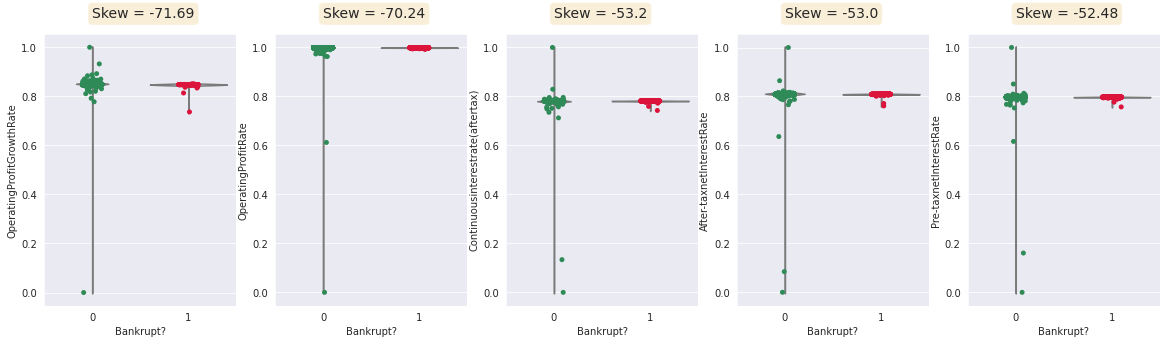

In [17]:

f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(data, 'Bankrupt?', bottom_skew_neg.index[0], bottom_skew_neg[0], ax0)
strip_violin(data, 'Bankrupt?', bottom_skew_neg.index[1], bottom_skew_neg[1], ax1)
strip_violin(data, 'Bankrupt?', bottom_skew_neg.index[2], bottom_skew_neg[2], ax2)
strip_violin(data, 'Bankrupt?', bottom_skew_neg.index[3], bottom_skew_neg[3], ax3)
strip_violin(data, 'Bankrupt?', bottom_skew_neg.index[4], bottom_skew_neg[4], ax4)

plt.savefig('negatively_skewed_data_violin_strip.png')
plt.show()

In [18]:
data.shape

(6819, 96)

In [19]:
# Inspired by outlier transformation code from MARTO93
# https://www.kaggle.com/marto24/bankruptcy-detection

def outliers_removal(feature,feature_name,dataset):
  # Identify 25th & 75th quartiles

  q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
  print(f"'Quartile 25: {q25} | Quartile 75: {q75}")
  feat_iqr = q75 - q25
  print(f"iqr: {feat_iqr}")
  
  feat_cut_off = feat_iqr*0.25
  feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
  print(f"Cut Off: {feat_cut_off}")
  print(f"{feature_name}, Lower: {feat_lower}")
  print(f"{feature_name}, Upper: {feat_upper}")
  
  outliers = [x for x in feature if x < feat_lower or x > feat_upper]
  print(f"{feature_name}, outliers for close to bankruptcy cases: {len(outliers)}")
  #print(feature_name + ' outliers:{}'.format(outliers))

  dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
  print('-' * 65)
  
  return dataset

for col in data:
    data_no_outliers = outliers_removal(data[col],str(col),data)

'Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
Bankrupt?, Lower: 0.0
Bankrupt?, Upper: 0.0
Bankrupt?, outliers for close to bankruptcy cases: 220
-----------------------------------------------------------------
'Quartile 25: 0.47652708038804703 | Quartile 75: 0.535562813825379
iqr: 0.05903573343733193
Cut Off: 0.014758933359332982
ROA(C)beforeinterestanddepreciationbeforeinterest, Lower: 0.46176814702871405
ROA(C)beforeinterestanddepreciationbeforeinterest, Upper: 0.5503217471847119
ROA(C)beforeinterestanddepreciationbeforeinterest, outliers for close to bankruptcy cases: 2345
-----------------------------------------------------------------
'Quartile 25: 0.53554295682512 | Quartile 75: 0.58915721761884
iqr: 0.05361426079372
Cut Off: 0.01340356519843
ROA(A)beforeinterestand%aftertax, Lower: 0.52213939162669
ROA(A)beforeinterestand%aftertax, Upper: 0.60256078281727
ROA(A)beforeinterestand%aftertax, outliers for close to bankruptcy cases: 2494
-------------------------------

In [20]:
new_skew_pos = data_no_outliers.skew()[top_skew_pos.index]
new_skew_neg = data_no_outliers.skew()[bottom_skew_neg.index]

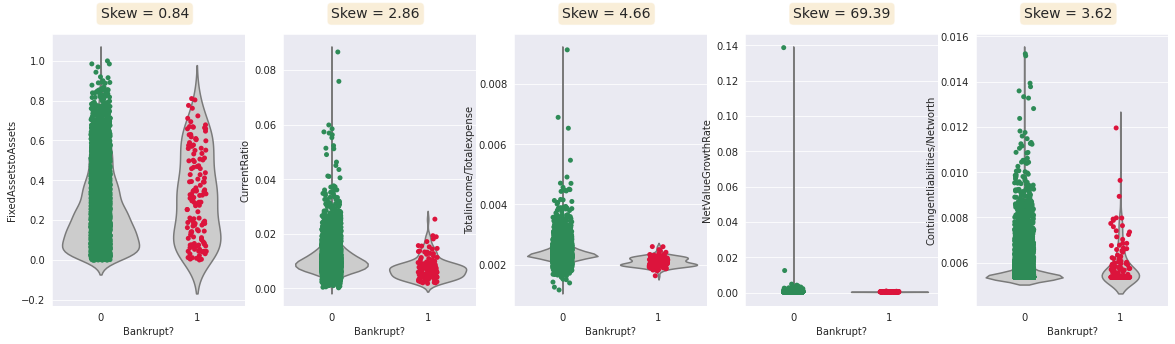

In [21]:
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(data_no_outliers, 'Bankrupt?', top_skew_pos.index[0], new_skew_pos[0], ax0)
strip_violin(data_no_outliers, 'Bankrupt?', top_skew_pos.index[1], new_skew_pos[1], ax1)
strip_violin(data_no_outliers, 'Bankrupt?', top_skew_pos.index[2], new_skew_pos[2], ax2)
strip_violin(data_no_outliers, 'Bankrupt?', top_skew_pos.index[3], new_skew_pos[3], ax3)
strip_violin(data_no_outliers, 'Bankrupt?', top_skew_pos.index[4], new_skew_pos[4], ax4)

plt.savefig('prev_skew_data_after_outlier_removal_pos.png')
plt.show()

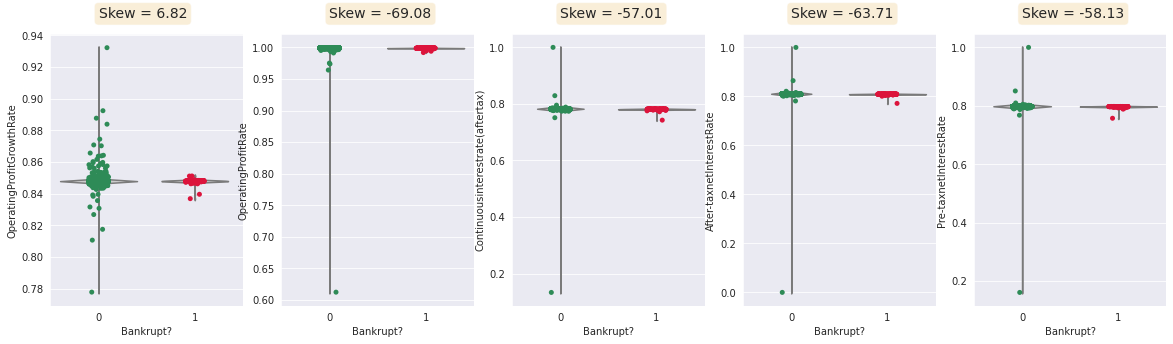

In [22]:
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5, figsize=(20,5))

strip_violin(data_no_outliers, 'Bankrupt?', bottom_skew_neg.index[0], new_skew_neg[0], ax0)
strip_violin(data_no_outliers, 'Bankrupt?', bottom_skew_neg.index[1], new_skew_neg[1], ax1)
strip_violin(data_no_outliers, 'Bankrupt?', bottom_skew_neg.index[2], new_skew_neg[2], ax2)
strip_violin(data_no_outliers, 'Bankrupt?', bottom_skew_neg.index[3], new_skew_neg[3], ax3)
strip_violin(data_no_outliers, 'Bankrupt?', bottom_skew_neg.index[4], new_skew_neg[4], ax4)

plt.savefig('prev_skew_data_after_outlier_removal_neg.png')

plt.show()

In [24]:
data_no_outliers.shape

(5037, 96)

## Data Types

In [25]:
def cat_num (data_frame):
  categorical_features = data_frame.select_dtypes(include = ["object", 'category']).columns
  numerical_features = data_frame.select_dtypes(include = ["float64"]).columns
  int_features = data_frame.select_dtypes(include = ['int64']).columns
  return categorical_features, numerical_features, int_features

In [26]:
features = cat_num(data_no_outliers)
print(f'''There are {len(features[0])} categorical features.
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features.''')

There are 0 categorical features.
There are 93 numerical features.
There are 3 integer features.


In [27]:
features[2]

Index(['Bankrupt?', 'Liability-AssetsFlag', 'NetIncomeFlag'], dtype='object')

In [28]:
data_no_outliers.NetIncomeFlag.value_counts()

1    5037
Name: NetIncomeFlag, dtype: int64

In [29]:
data_no_outliers['Liability-AssetsFlag'].value_counts()

0    5037
Name: Liability-AssetsFlag, dtype: int64

In [30]:
data_no_outliers[min0_max1+list(features[2])] = data_no_outliers[min0_max1+list(features[2])].astype('category')
data_no_outliers['Bankrupt?'] = data_no_outliers['Bankrupt?'].astype('int64')

features = cat_num(data_no_outliers)
cat_features = list(features[0])
num_features = list(features[1])
int_features = list(features[2])
print(f'''There are {len(features[0])} categorical features: {cat_features}
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features: {int_features}.''')

There are 71 categorical features: ['ROA(C)beforeinterestanddepreciationbeforeinterest', 'ROA(A)beforeinterestand%aftertax', 'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin', 'RealizedSalesGrossMargin', 'OperatingProfitRate', 'Pre-taxnetInterestRate', 'After-taxnetInterestRate', 'Non-industryincomeandexpenditure/revenue', 'Continuousinterestrate(aftertax)', 'Cashflowrate', 'Taxrate(A)', 'NetValuePerShare(B)', 'NetValuePerShare(A)', 'NetValuePerShare(C)', 'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare', 'OperatingProfitPerShare(Yuan¥)', 'PerShareNetprofitbeforetax(Yuan¥)', 'RealizedSalesGrossProfitGrowthRate', 'OperatingProfitGrowthRate', 'After-taxNetProfitGrowthRate', 'RegularNetProfitGrowthRate', 'ContinuousNetProfitGrowthRate', 'TotalAssetReturnGrowthRateRatio', 'CashReinvestment%', 'InterestExpenseRatio', 'Debtratio%', 'Networth/Assets', 'Long-termfundsuitabilityratio(A)', 'Borrowingdependency', 'Contingentliabilities/Networth', 'Operatingprofit/Paid-in

## Correlations

In [31]:
def mask_corr_graph (data_frame, columnsof_interest, fig_size=(7,5), show_corr=True, fig_name='feature_corr'):
  sns.set_theme(color_codes=True)

  features_corr = data_frame[columnsof_interest].corr()

  mask = np.zeros_like(features_corr)
  mask[np.triu_indices_from(mask)] = True

  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=fig_size)
    ax = sns.heatmap(features_corr, annot=show_corr, linewidths=0.5, cmap="RdYlGn", mask=mask)

  ax.figure.savefig(f"{fig_name}.png")
    
  return ax

In [32]:
data_no_outliers.shape

(5037, 96)

<AxesSubplot:>

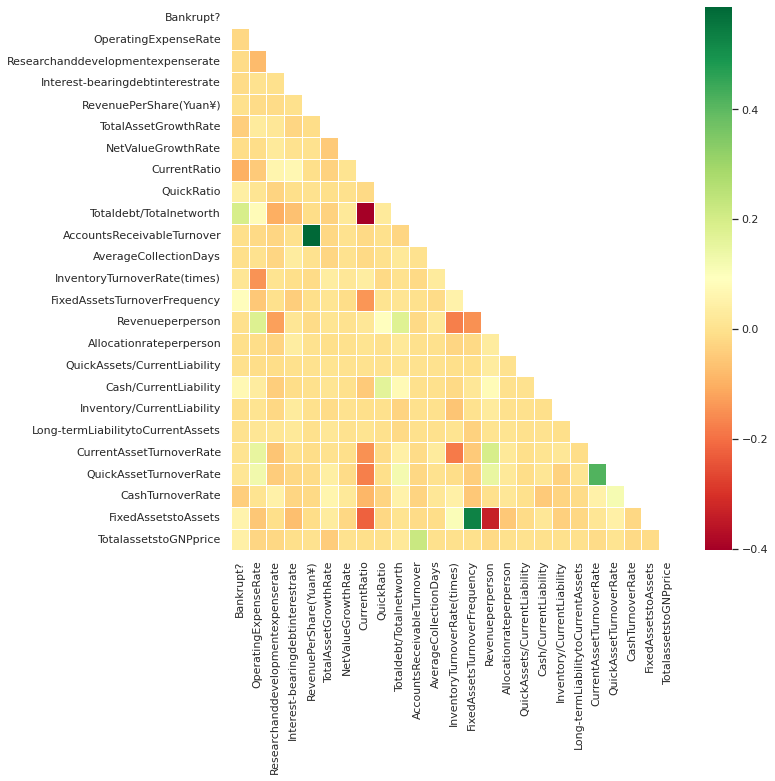

In [33]:
mask_corr_graph(data_no_outliers, data_no_outliers.columns, fig_size=(10,10), show_corr=False)

In [34]:
train_corr = data_no_outliers.corr()['Bankrupt?'].drop(labels=['Bankrupt?'])
top10_bottom10_corr = train_corr[(train_corr >= train_corr.quantile(q=0.90)) | 
                            (train_corr <= train_corr.quantile(q=0.10))]
top10_bottom10_corr

TotalAssetGrowthRate           -0.042188
CurrentRatio                   -0.101444
Totaldebt/Totalnetworth         0.193190
FixedAssetsTurnoverFrequency    0.087509
Cash/CurrentLiability           0.071153
CashTurnoverRate               -0.041736
Name: Bankrupt?, dtype: float64

In [35]:
top10_bottom10 = list(top10_bottom10_corr.index)

In [36]:
data_no_outliers['Bankrupt?'] = data_no_outliers['Bankrupt?'].astype('category')

features = cat_num(data_no_outliers)
cat_features = list(features[0])
num_features = list(features[1])
int_features = list(features[2])
print(f'''There are {len(features[0])} categorical features.
There are {len(features[1])} numerical features.
There are {len(features[2])} integer features.''')

There are 72 categorical features.
There are 24 numerical features.
There are 0 integer features.


## Split Data

In [37]:
bankrupt = data_no_outliers['Bankrupt?'].copy()
data_no_outliers = data_no_outliers.drop(columns='Bankrupt?')
data_no_outliers.shape

(5037, 95)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(data_no_outliers, bankrupt, test_size=0.2, random_state=100)

print(f'''X_train shape {X_train.shape}
y_train shape {y_train.shape}
X_test shape {X_test.shape}
y_test shape {y_test.shape}''')

X_train shape (4029, 95)
y_train shape (4029,)
X_test shape (1008, 95)
y_test shape (1008,)


## Pipeline: Preprocesseor

In [39]:
preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), num_features),
                                               ('imputer', SimpleImputer(strategy='most_frequent'), cat_features[1:])])


# Model

### Model Stats

In [40]:
from operator import mod
def evaluating_model (y_true, y_pred, model_name, train_test):
  print(f'''
  {model_name} for {train_test} Data
  MSE: {round(mean_squared_error(y_true, y_pred), 4)}
  RMSE: {round((mean_squared_error(y_true, y_pred)**0.5),4)}
  MAE: {round(mean_absolute_error(y_true, y_pred),4)}
  R_SQR: {round(r2_score(y_true, y_pred),4)}
  EXV: {round(explained_variance_score(y_true, y_pred),4)}
  ME: {round(max_error(y_true, y_pred),4)}
  RMSLE: {round((mean_squared_log_error(y_true, y_pred)**0.5),4)}
  ''')
  return

  # Confusion matrix {confusion_matrix(x_data,y_pred)}
def eval_classification (y_pred, y_true, x_data, model_name, train_test):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

  print(f'''
  {model_name} for {train_test} Data
  Accuracy score {round(accuracy_score(y_true, y_pred),4)}
  F1-Score {round(f1_score(y_true, y_pred),4)}
  FPR {fpr}
  tpr {tpr}
  ''')

  f, (ax0, ax1) = plt.subplots(1,2, figsize=(10,5))
  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax0, 
                                   name=f'{model_name} {train_test} ROC_Curve')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax1, 
                                          name=f'{model_name} {train_test} Precision/Recall')
  plt.savefig(f'{model_name}_{train_test}_roc_prec_rec_curves.png')
  plt.show()
  return

## Pipeline: Logistic Regression

In [41]:
LR_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('regressor', LogisticRegression(max_iter=400))
])

In [42]:
lr_model = LR_pipe.fit(X_train, y_train)

In [43]:
train_pred_lr = lr_model.predict(X_train)
test_pred_lr = lr_model.predict(X_test)

### LG Evaluation


  LG for Train Data
  MSE: 0.0243
  RMSE: 0.156
  MAE: 0.0243
  R_SQR: 0.0236
  EXV: 0.0445
  ME: 1.0
  RMSLE: 0.1081
  

  LG for Train Data
  Accuracy score 0.9757
  F1-Score 0.1404
  FPR [0.00000000e+00 7.64136526e-04 1.00000000e+00]
  tpr [0.        0.0776699 1.       ]
  


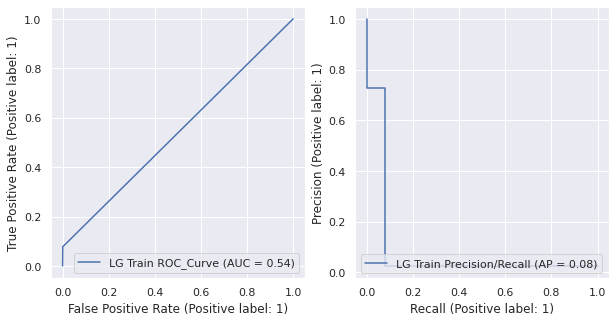

---------------------

  LG for Test Data
  MSE: 0.0317
  RMSE: 0.1782
  MAE: 0.0317
  R_SQR: -0.0025
  EXV: 0.0255
  ME: 1.0
  RMSLE: 0.1235
  

  LG for Test Data
  Accuracy score 0.9683
  F1-Score 0.1111
  FPR [0.         0.00102564 1.        ]
  tpr [0.         0.06060606 1.        ]
  


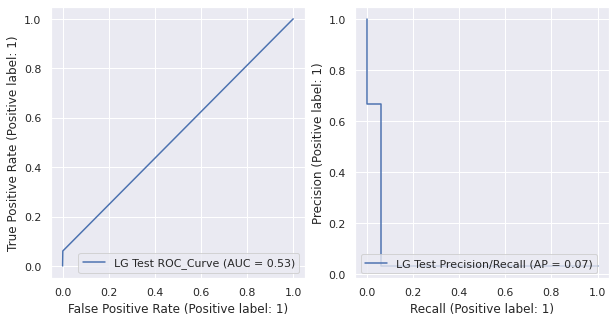

In [44]:
evaluating_model(y_train, train_pred_lr,'LG', 'Train')
eval_classification(train_pred_lr, y_train, X_train, 'LG', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_lr,'LG', 'Test')
eval_classification(test_pred_lr, y_test, X_test, 'LG', 'Test')

## Pipeline: Linear Support Vector Classification

In [45]:
LSVC_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('linearSVC', LinearSVC(max_iter=140000))
])

In [46]:
LSVC_model = LSVC_pipe.fit(X_train, y_train)

In [47]:
train_pred_LSVC = LSVC_model.predict(X_train)
test_pred_LSVC = LSVC_model.predict(X_test)

### LSVC Evaluation


  LSVC for Train Data
  MSE: 0.0251
  RMSE: 0.1583
  MAE: 0.0251
  R_SQR: -0.0063
  EXV: 0.017
  ME: 1.0
  RMSLE: 0.1097
  

  LSVC for Train Data
  Accuracy score 0.9749
  F1-Score 0.0734
  FPR [0.0000000e+00 5.0942435e-04 1.0000000e+00]
  tpr [0.         0.03883495 1.        ]
  


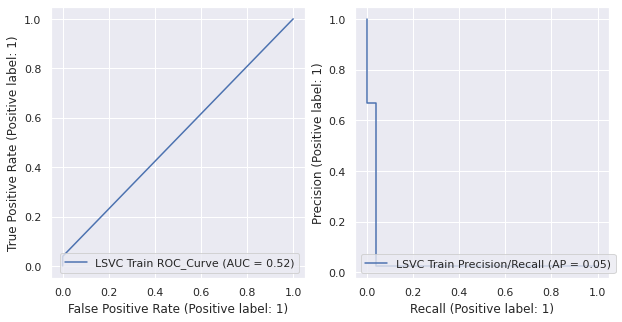

---------------------

  LSVC for Test Data
  MSE: 0.0327
  RMSE: 0.1809
  MAE: 0.0327
  R_SQR: -0.0338
  EXV: -0.004
  ME: 1.0
  RMSLE: 0.1254
  

  LSVC for Test Data
  Accuracy score 0.9673
  F1-Score 0.0571
  FPR [0.         0.00102564 1.        ]
  tpr [0.         0.03030303 1.        ]
  


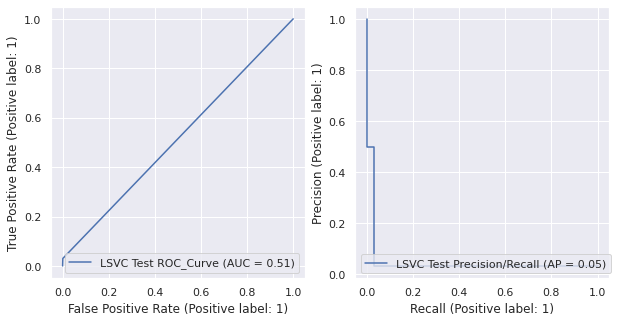

In [48]:
evaluating_model(y_train, train_pred_LSVC,'LSVC', 'Train')
eval_classification(train_pred_LSVC, y_train, X_train, 'LSVC', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_LSVC, 'LSVC', 'Test')
eval_classification(test_pred_LSVC, y_test, X_test, 'LSVC', 'Test')

## Pipeline: Gaussian Naive Bayes

In [49]:
GNB_pipe = Pipeline(steps= [('preprocessor', preprocessor),
                            ('GaussianNB', GaussianNB())
])

In [50]:
GNB_model = GNB_pipe.fit(X_train, y_train)

In [51]:
train_pred_GNB = GNB_model.predict(X_train)
test_pred_GNB = GNB_model.predict(X_test)

### GNB Evaluation


  GNB for Train Data
  MSE: 0.829
  RMSE: 0.9105
  MAE: 0.829
  R_SQR: -32.2779
  EXV: -4.6909
  ME: 1.0
  RMSLE: 0.6311
  

  GNB for Train Data
  Accuracy score 0.171
  F1-Score 0.0581
  FPR [0.         0.85073867 1.        ]
  tpr [0. 1. 1.]
  


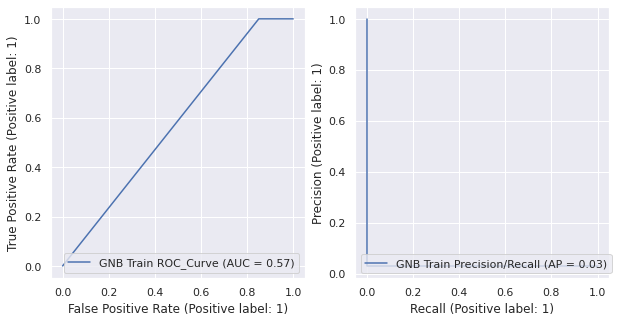

---------------------

  GNB for Test Data
  MSE: 0.8492
  RMSE: 0.9215
  MAE: 0.8492
  R_SQR: -25.8173
  EXV: -3.2562
  ME: 1.0
  RMSLE: 0.6388
  

  GNB for Test Data
  Accuracy score 0.1508
  F1-Score 0.0675
  FPR [0.         0.87589744 1.        ]
  tpr [0.         0.93939394 1.        ]
  


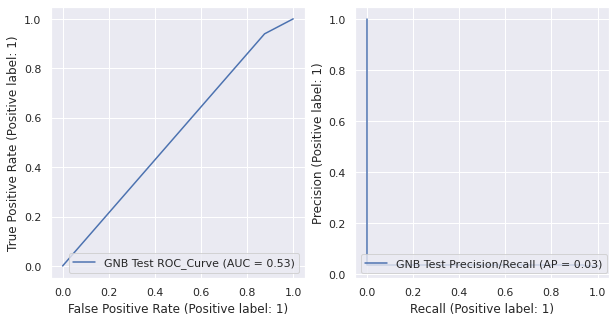

In [52]:
evaluating_model(y_train, train_pred_GNB, 'GNB', 'Train')
eval_classification(train_pred_GNB, y_train, X_train,'GNB', 'Train')

print("---------------------")
evaluating_model(y_test, test_pred_GNB,'GNB', 'Test')
eval_classification(test_pred_GNB, y_test, X_test, 'GNB', 'Test')